[*********************100%***********************]  1 of 1 completed


                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-06-01  325.929993  333.529999  324.720001  332.579987  326.339417   
2023-06-02  334.250000  337.500000  332.549988  335.399994  329.106506   
2023-06-05  335.220001  338.559998  334.660004  335.940002  329.636383   
2023-06-06  335.329987  335.369995  332.170013  333.679993  327.418793   
2023-06-07  331.649994  334.489990  322.500000  323.380005  317.312073   
...                ...         ...         ...         ...         ...   
2024-07-25  428.799988  429.799988  417.510010  418.399994  413.760712   
2024-07-26  418.200012  428.920013  417.269989  425.269989  420.554474   
2024-07-29  431.579987  432.149994  424.700012  426.730011  421.998322   
2024-07-30  427.720001  429.049988  417.359985  422.920013  418.230591   
2024-07-31  420.500000  421.779999  412.209991  418.350006  413.711273   

              Volume  
Date          

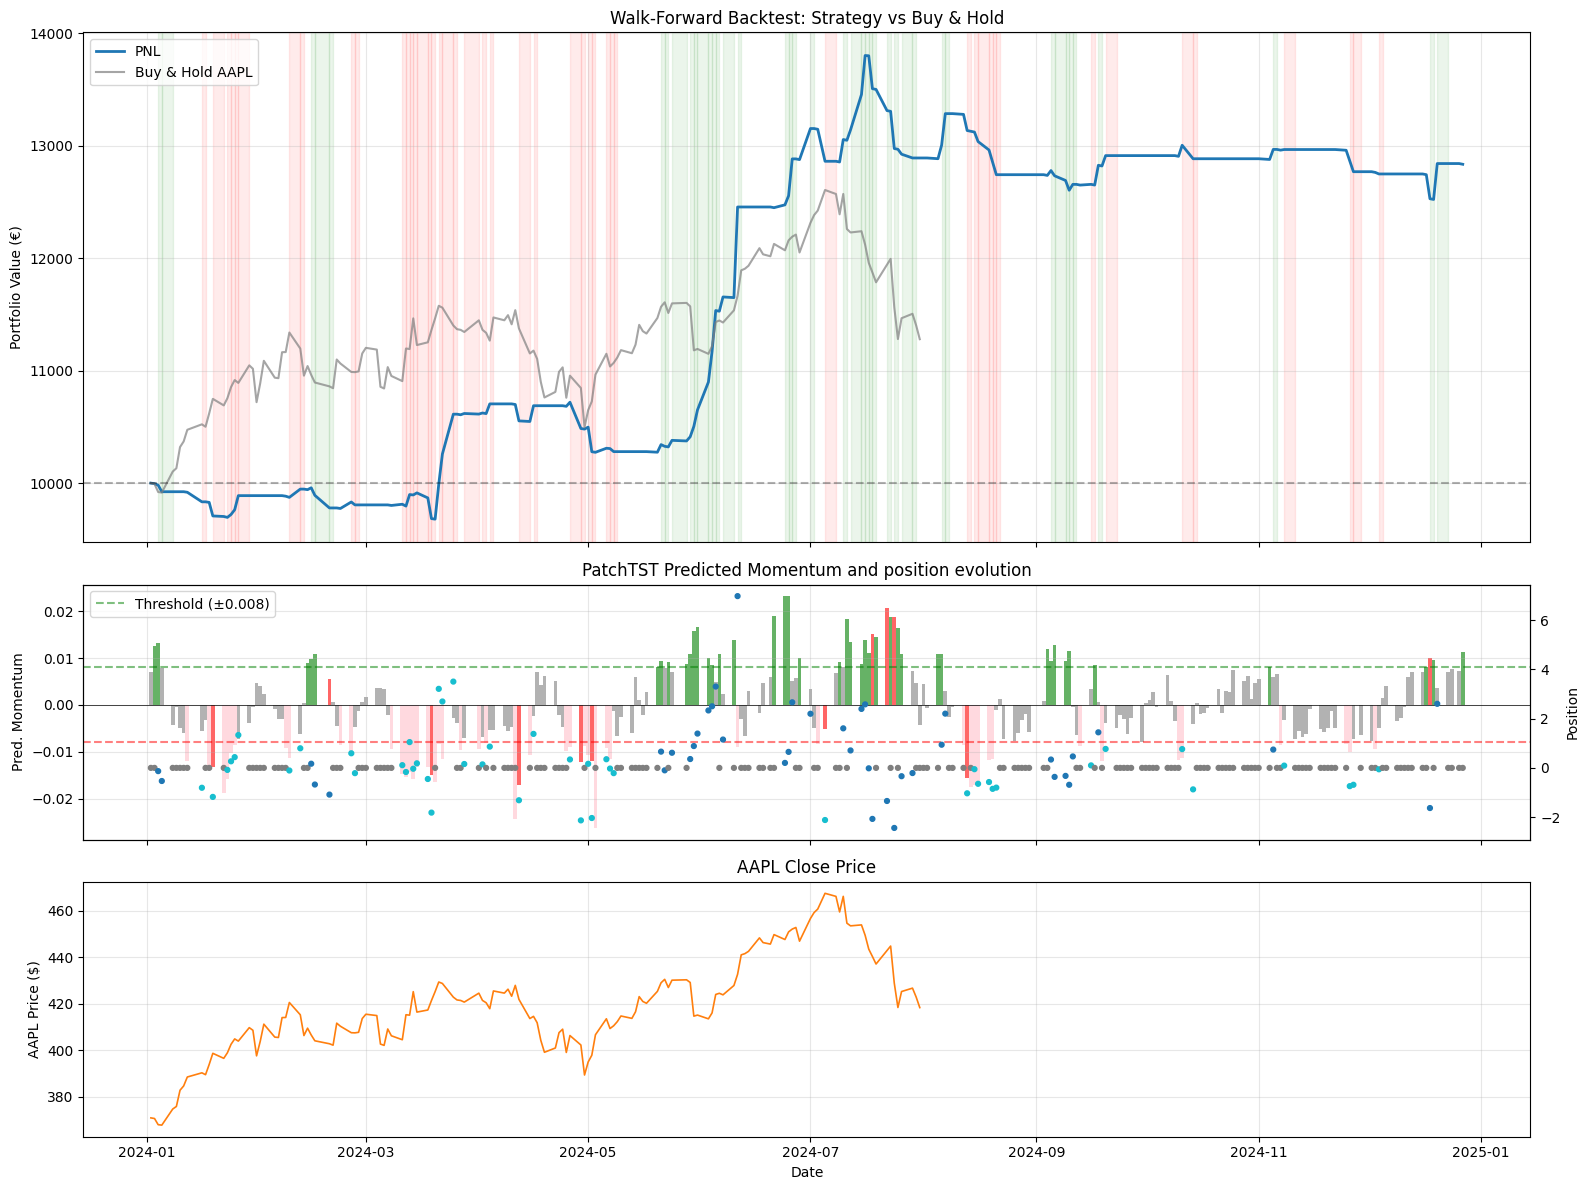

Strategy Return:   +28.36%
Buy & Hold Return: +nan%
Signal Changes:    92
Long/Short/Flat:   42 / 48 / 148 days


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import os

logfile = 'from_trained_test.csv'
THRESHOLD = 0.008
# Log einlesen

from ticker_data import get_ticker
df_log = pd.read_csv(logfile, parse_dates=['date'], index_col='date')

df_log.index = pd.to_datetime(df_log.index).tz_localize(None).normalize()
# AAPL Close-Preise für den gleichen Zeitraum
#df_aapl = yf.download('AAPL', start='2021-06-01', end='2025-01-01')
df_aapl = get_ticker('AAPL', start='2023-06-01', end='2025-01-01')

print (df_aapl)
aapl_close = df_aapl['Close'].squeeze()
aapl_close.index = pd.to_datetime(aapl_close.index).tz_localize(None).normalize()
aapl_bt = aapl_close.reindex(df_log.index)          # NaN where missing
#aapl_bt = aapl_close.reindex(pd.to_datetime(df_log.index))
#aapl_bt = aapl_close.loc[df_log.index]

# Buy & Hold normalisiert auf gleichen Startwert
bh_normalized = aapl_bt / aapl_bt.iloc[0] * 10000

#print(df_log)
#print(aapl_bt)
fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True,
                         gridspec_kw={'height_ratios': [2, 1, 1]})

# --- Plot 1: Portfolio P&L vs Buy & Hold ---
ax1 = axes[0]
ax1.plot(df_log.index, df_log['portfolio_value'], label='PNL', linewidth=2, color='tab:blue')

ax1.plot(bh_normalized.index, bh_normalized.values, label='Buy & Hold AAPL', linewidth=1.5, color='tab:gray', alpha=0.7)
ax1.axhline(10000, color='black', linestyle='--', alpha=0.3)
ax1.set_ylabel('Portfolio Value (€)')
ax1.set_title('Walk-Forward Backtest: Strategy vs Buy & Hold')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

#ax3.relim()               # recompute limits from artists on the axes
#ax3.autoscale_view(scalex=False, scaley=True)  # only autoscale y

# Signals als Hintergrundfarbe
for j in range(len(df_log) - 1):
    sig = df_log['in_market'].iloc[j]
    if sig == 1:
        ax1.axvspan(df_log.index[j], df_log.index[j+1], alpha=0.08, color='green')
    elif sig == -1:
        ax1.axvspan(df_log.index[j], df_log.index[j+1], alpha=0.08, color='red')

# --- Plot 2: Predicted Momentum + Threshold ---
ax2 = axes[1]
colors = ['green' if s == 1 else 'pink' if s == -1 else 'red' if s == -2  else 'gray' for s in df_log['signal']]
ax2.bar(df_log.index, df_log['pred_momentum'], color=colors, alpha=0.6, width=1)
ax2.axhline(THRESHOLD, color='green', linestyle='--', alpha=0.5, label=f'Threshold (±{THRESHOLD})')
ax2.axhline(-THRESHOLD, color='red', linestyle='--', alpha=0.5)
ax2.axhline(0, color='black', linewidth=0.5)
ax2.set_ylabel('Pred. Momentum')
ax2.set_title('PatchTST Predicted Momentum and position evolution')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

#draw position evolution
ax_openpos = ax2.twinx()
pos_return_normalized =  100
position_return = df_log['position_return'] * pos_return_normalized
color_map = {-2: 'tab:red', -1: 'tab:cyan', 0: 'tab:gray', 1: 'tab:blue', 2: 'tab:green'}
colors = df_log['in_market'].map(color_map)
ax_openpos.scatter(df_log.index, position_return, c=colors, s=12, label='Position')
ax_openpos.set_ylabel('Position')


# --- Plot 3: AAPL Kurs ---
ax3 = axes[2]

ax3.plot(aapl_bt.index, aapl_bt.values, color='tab:orange', linewidth=1.2)


ax3.set_ylabel('AAPL Price ($)')
ax3.set_title('AAPL Close Price')
ax3.set_xlabel('Date')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('walk_forward_results.png', dpi=150, bbox_inches='tight')
plt.show()



# Statistiken
total_return = (df_log['portfolio_value'].iloc[-1] / 10000 - 1) * 100
bh_return = (aapl_bt.iloc[-1] / aapl_bt.iloc[0] - 1) * 100
n_trades = (df_log['signal'].diff().fillna(0) != 0).sum()
long_days = (df_log['signal'] == 1).sum()
short_days = (df_log['signal'] == -1).sum()
flat_days = (df_log['signal'] == 0).sum()

print(f"Strategy Return:   {total_return:+.2f}%")
print(f"Buy & Hold Return: {bh_return:+.2f}%")
print(f"Signal Changes:    {n_trades}")
print(f"Long/Short/Flat:   {long_days} / {short_days} / {flat_days} days")